In [18]:
#If opening in colab run this cell
!git clone https://github.com/connordouglas10/DS-Tech-2025January.git
%cd DS-Tech-2025January/Assignments

Cloning into 'DS-Tech-2025January'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 337 (delta 6), reused 14 (delta 6), pack-reused 321 (from 1)
Receiving objects: 100% (337/337), 97.09 MiB | 20.39 MiB/s, done.
Resolving deltas: 100% (97/97), done.
/content/DS-Tech-2025January/Assignments/DS-Tech-2025January/Assignments


# IF OPENING IN COLAB, REMEMBER TO SAVE THIS NOTEBOOK TO GOOGLE DRIVE!

# Predicting Customer Complaints

Our problem setting is similar that which we saw in class. You've been hired by Trans American Airlines (TAA) as a data science consultant. Your job is to identify customer service issues in tweets, so the issues can be directed to the customer experience team.

We will be trying a variety of text representation techniques and modeling approaches to see which work the best.

In [19]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pylab as plt
%matplotlib inline

__1. Load the data. Print a portion of the DataFrame.__

In [20]:
import numpy as np
import pandas as pd

# If necessary change the path below so that it points to your file.
data_path = "./data/data-hw4.csv"

df = pd.read_csv(data_path)

# Your code here
print(df.head())

       tweet_id airline_sentiment  airline_sentiment_confidence  \
0  5.703060e+17           neutral                        1.0000   
1  5.703010e+17          positive                        0.3486   
2  5.703010e+17           neutral                        0.6837   
3  5.703010e+17          negative                        1.0000   
4  5.703010e+17          negative                        1.0000   

  negativereason  negativereason_confidence        name  retweet_count  \
0            NaN                        NaN     cairdin              0   
1            NaN                     0.0000    jnardino              0   
2            NaN                        NaN  yvonnalynn              0   
3     Bad Flight                     0.7033    jnardino              0   
4     Can't Tell                     1.0000    jnardino              0   

                                                text    tweet_created  \
0                          @TAA What @dhepburn said.  2/24/2015 11:35   
1  @TA

__2. Define a binary target variable for "Customer Service Issue". Keep only this binary target variable and the text in the DataFrame. What portion of tweets are about a customer service issue?__

In [21]:
# Your code goes here. this was my initial attempt
#keywords = ["change", "help", "support", "complaint", "service", "issue", "problem", "locked"]
#df["customer_service_issue"] = df["text"].str.contains('|'.join(keywords), case=False, na=False).astype(int)
#df = df[["text", "customer_service_issue"]]
#proportion = df["customer_service_issue"].mean()

#print(df)
#print(f"Proportion of tweets about customer service issues: {proportion:.2%}")

In [22]:
print(df['negativereason'].value_counts())
df['is_customer_service_issue'] = (df['negativereason'] == "Customer Service Issue").astype(int)

df = df[['text', 'is_customer_service_issue']]

portion = df['is_customer_service_issue'].mean()
print(f"Portion of tweets about a customer service issue: {portion:.2%}")

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64
Portion of tweets about a customer service issue: 19.88%


__3. To make things technically easier, we will not do cross-validation on this assignment. Instead, split the data into 80% training data, 20% test data. Then, split the train set into 80% sub-train, 20% validation data.__

In [23]:
# Your code goes here
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
sub_train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
y_train = sub_train_data['is_customer_service_issue'].to_numpy()
y_val = val_data['is_customer_service_issue'].to_numpy()

print(f"Sub-train data size: {len(sub_train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Sub-train data size: 9369
Validation data size: 2343
Test data size: 2928


__4. Create and train a binary vector representation along with a TF-IDF representation of the words in each tweet. Then, use apply these vectorizors to create two representations of the training and validation set.__

In [24]:
binary_vectorizer = CountVectorizer(binary=True)
tfidf_vectorizer = TfidfVectorizer()

#Your code goes here
binary_train = binary_vectorizer.fit_transform(sub_train_data['text'])
tfidf_train = tfidf_vectorizer.fit_transform(sub_train_data['text'])

binary_val = binary_vectorizer.transform(val_data['text'])
tfidf_val = tfidf_vectorizer.transform(val_data['text'])

#printing
print("Binary Train Shape:", binary_train.shape)
print("TF-IDF Train Shape:", tfidf_train.shape)
print("Binary Validation Shape:", binary_val.shape)
print("TF-IDF Validation Shape:", tfidf_val.shape)
print("Sample Binary Vectorizer Features:", binary_vectorizer.get_feature_names_out()[:10])
print("Sample TF-IDF Vectorizer Features:", tfidf_vectorizer.get_feature_names_out()[:10])

Binary Train Shape: (9369, 11697)
TF-IDF Train Shape: (9369, 11697)
Binary Validation Shape: (2343, 11697)
TF-IDF Validation Shape: (2343, 11697)
Sample Binary Vectorizer Features: ['00' '000' '000114' '000ft' '0011' '0016' '00a' '00am' '00p' '00pm']
Sample TF-IDF Vectorizer Features: ['00' '000' '000114' '000ft' '0011' '0016' '00a' '00am' '00p' '00pm']


__5. Build 2 logistic regression models, one for each representation. For each of these, try different values for the hyperparameter C.__

Try to optimize generalization performance, evaluated based on ROC Area on the validation set. Try looping over values of C for each model; in this loop train and evaluate + print the AUC. Report the best hyperparameter you found for the model for each representation (binary and TFIDF). Pick one model to move forward with for each representation Why did you select this one?



In [25]:
# Your code goes here
C_values = [0.01, 0.1, 1, 10, 100]

best_auc_binary = 0
best_C_binary = None
print("\nBinary Vectorization Logistic Regression")
for C in C_values:
    model = LogisticRegression(C=C, random_state=42, max_iter=1000)
    model.fit(binary_train, sub_train_data['is_customer_service_issue'])
    preds = model.predict_proba(binary_val)[:, 1]
    auc = metrics.roc_auc_score(val_data['is_customer_service_issue'], preds)
    print(f"C={C}: AUC={auc:.4f}")
    if auc > best_auc_binary:
        best_auc_binary = auc
        best_C_binary = C

print(f"Best Binary Model: C={best_C_binary}, AUC={best_auc_binary:.4f}")

best_auc_tfidf = 0
best_C_tfidf = None
print("\nTF-IDF Vectorization Logistic Regression")
for C in C_values:
    model = LogisticRegression(C=C, random_state=42, max_iter=1000)
    model.fit(tfidf_train, sub_train_data['is_customer_service_issue'])
    preds = model.predict_proba(tfidf_val)[:, 1]
    auc = metrics.roc_auc_score(val_data['is_customer_service_issue'], preds)
    print(f"C={C}: AUC={auc:.4f}")
    if auc > best_auc_tfidf:
        best_auc_tfidf = auc
        best_C_tfidf = C

print(f"Best TF-IDF Model: C={best_C_tfidf}, AUC={best_auc_tfidf:.4f}")


Binary Vectorization Logistic Regression
C=0.01: AUC=0.8603
C=0.1: AUC=0.8820
C=1: AUC=0.8741
C=10: AUC=0.8498
C=100: AUC=0.8254
Best Binary Model: C=0.1, AUC=0.8820

TF-IDF Vectorization Logistic Regression
C=0.01: AUC=0.8561
C=0.1: AUC=0.8688
C=1: AUC=0.8824
C=10: AUC=0.8735
C=100: AUC=0.8478
Best TF-IDF Model: C=1, AUC=0.8824


__6. We will now try using a transformer embedding representations of text. This helps to capture the sequential dependencies of the text. The SentenceTransformers library enables easy embedding representations. Embed the training, validation, and test sets and store under a new variable name. We've started you with the training set. Print the dimensionality of the embeddings (using X_train_embeddings.shape[1]).__

This might take a bit of time!

In [26]:
# Install the necessary library
!pip install -q sentence-transformers

In [27]:
# Import the SentenceTransformer class
from sentence_transformers import SentenceTransformer

# Load a pre-trained SentenceTransformer model
# You can choose a model like 'all-MiniLM-L6-v2', 'paraphrase-MiniLM-L3-v2', etc.
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Compute embeddings for the training set with model.encode
X_train_embeddings = model.encode(sub_train_data['text'].to_numpy())

# Display the embeddings
print("Embeddings shape:", X_train_embeddings.shape)
print("Example embedding for the first sentence:", X_train_embeddings[0])

#Your code goes here
X_train_embeddings = model.encode(sub_train_data['text'].to_numpy())
X_val_embeddings = model.encode(val_data['text'].to_numpy())
X_test_embeddings = model.encode(test_data['text'].to_numpy())

print("Training embeddings shape:", X_train_embeddings.shape)
print("Number of features in the training embeddings:", X_train_embeddings.shape[1])
print("Validation embeddings shape:", X_val_embeddings.shape)
print("Number of features in the validation embeddings:", X_val_embeddings.shape[1])
print("Test embeddings shape:", X_test_embeddings.shape)
print("Number of features in the test embeddings:", X_test_embeddings.shape[1])
print("Example training embedding for the first sentence:", X_train_embeddings[0])

Embeddings shape: (9369, 384)
Example embedding for the first sentence: [-8.44629779e-02 -3.94746140e-02  5.20697841e-03 -3.35111778e-04
  4.83640516e-03 -6.01243302e-02  4.76734228e-02 -5.44093475e-02
 -4.24762964e-02  3.65229929e-03 -3.97134805e-04  4.03424911e-02
  1.50119225e-02 -2.23821551e-02 -1.71623696e-02 -4.19211201e-02
 -5.58235077e-03 -1.07233517e-01  7.82757811e-03 -1.60919596e-02
 -4.57161553e-02 -3.97995301e-02  5.63900033e-03  3.30961309e-02
 -1.98226366e-02 -3.04024611e-02  3.98921175e-03  1.67138744e-02
 -8.80032852e-02 -4.19328250e-02 -7.34902844e-02  2.56484449e-02
 -3.97526547e-02 -5.29568903e-02  6.48230240e-02 -4.98128794e-02
  2.44382620e-02 -2.42588930e-02  5.41358255e-02 -3.04307491e-02
  2.78340117e-03  3.10967164e-03  2.36990582e-02  4.64712828e-02
 -4.45728041e-02  6.81848228e-02  2.12394092e-02 -1.18468562e-02
  2.99585201e-02  6.27852371e-03 -7.29028089e-03  3.74464989e-02
  2.95961425e-02  1.14608919e-02 -9.58440304e-02 -2.08622292e-02
 -5.52312657e-02 -

__7. Build a logistic regression model using this new embedding representation as the features. Try different values for the hyperparameter C.__

Try to optimize generalization performance, evaluated based on ROC Area on the validation set. Report the best hyperparameter you found. Pick one model to move forward with. Why did you select this one?

In [28]:
#Your code goes here
C_values = [0.01, 0.1, 1, 10, 100]
best_auc = 0
best_C = None

print("\nLogistic Regression on SentenceTransformer Embeddings")
for C in C_values:
    model = LogisticRegression(C=C, random_state=42, max_iter=1000)
    model.fit(X_train_embeddings, sub_train_data['is_customer_service_issue'])
    preds = model.predict_proba(X_val_embeddings)[:, 1]
    auc = metrics.roc_auc_score(val_data['is_customer_service_issue'], preds)
    print(f"C={C}: AUC={auc:.4f}")
    if auc > best_auc:
        best_auc = auc
        best_C = C

print(f"Best model hyperparameter: C={best_C}, AUC={best_auc:.4f}")


Logistic Regression on SentenceTransformer Embeddings
C=0.01: AUC=0.8678
C=0.1: AUC=0.8775
C=1: AUC=0.8798
C=10: AUC=0.8752
C=100: AUC=0.8715
Best model hyperparameter: C=1, AUC=0.8798


__8. Now, we will do a similar process for training a neural network. Try two other set-ups, then train and evaluate each set-up on the validation set. Try adding a layer, changing the width of internal (hidden) layers (i.e. not input or output layers), or changing the number of epochs. Report the AUC of each set-up.__

__HINT: There is an example below of one architecture. Evaluate this performance with AUC on the validation set, then repeat this two more times with different network shapes.__

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Example input size (number of features from X_train_embeddings.shape[0])
input_size = X_train_embeddings.shape[1]

# Define a simple neural network model
def train_and_evaluate_nn(hidden_units, epochs):
  model = models.Sequential([
    layers.Input(shape=(input_size,)),  # Input layer
    layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
  ])

  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

  history = model.fit(X_train_embeddings, y_train, epochs=10, validation_data=(X_val_embeddings, y_val))


# Your code goes here
  preds = model.predict(X_val_embeddings)
  auc = metrics.roc_auc_score(y_val, preds)
  return auc

configurations = [{'hidden_units': 64, 'epochs': 10},{'hidden_units': 128, 'epochs': 15},{'hidden_units': 256, 'epochs': 10}]

for config in configurations:
    auc = train_and_evaluate_nn(config['hidden_units'], config['epochs'])
    print(f"Configuration: Hidden Units={config['hidden_units']}, Epochs={config['epochs']} -> AUC={auc:.4f}")

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8106 - loss: 0.4543 - val_accuracy: 0.8762 - val_loss: 0.3069
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8675 - loss: 0.3192 - val_accuracy: 0.8749 - val_loss: 0.3150
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8761 - loss: 0.3045 - val_accuracy: 0.8839 - val_loss: 0.2947
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8797 - loss: 0.2942 - val_accuracy: 0.8801 - val_loss: 0.3043
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8831 - loss: 0.2881 - val_accuracy: 0.8848 - val_loss: 0.2957
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8929 - loss: 0.2739 - val_accuracy: 0.8805 - val_loss: 0.2974
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8927 - loss: 0.2647 - val_accuracy: 0.8860 - val_loss: 0.2979
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8958 - loss: 0.2622 - val_accuracy: 0.

__9. Display one ROC curve and AUC figures for the following on the validation set. Plot all curves on a single graph:__
* The best logistic regression model using a binary representation
* The best logistic regression model using a TF-IDF representation
* The best logistic regression model using a SentenceTransformers embedding representation
* The best neural network using a SentenceTransformers embedding representation

You may need to copy code from various sections above to retrain each model on the best hyperparameter.


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


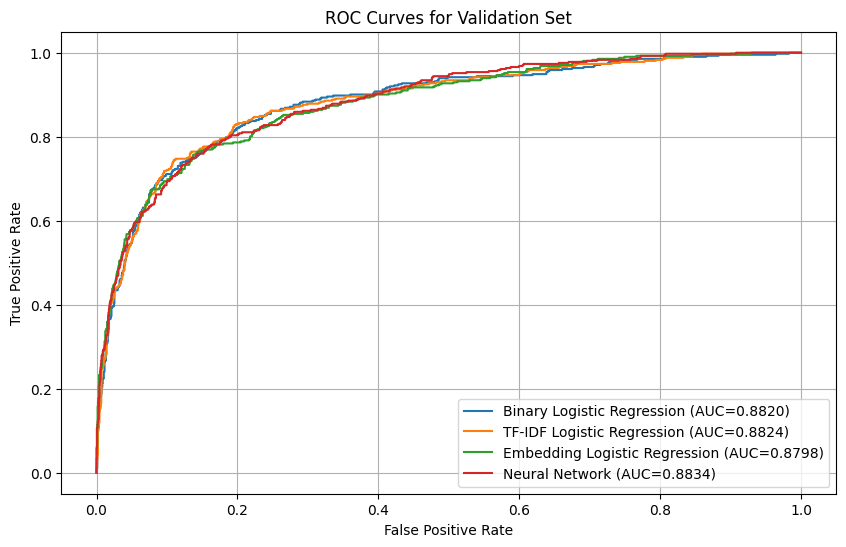

In [35]:
#Your code goes here
plt.figure(figsize=(10, 6))

#Logistic regression with binary representation
best_binary_model = LogisticRegression(C=0.1, random_state=42, max_iter=1000)
best_binary_model.fit(binary_train, y_train)
binary_preds = best_binary_model.predict_proba(binary_val)[:, 1]
binary_fpr, binary_tpr, _ = metrics.roc_curve(y_val, binary_preds)
binary_auc = metrics.roc_auc_score(y_val, binary_preds)
plt.plot(binary_fpr, binary_tpr, label=f"Binary Logistic Regression (AUC={binary_auc:.4f})")

#Logistic regression with TF-IDF representation
best_tfidf_model = LogisticRegression(C=1, random_state=42, max_iter=1000)
best_tfidf_model.fit(tfidf_train, y_train)
tfidf_preds = best_tfidf_model.predict_proba(tfidf_val)[:, 1]
tfidf_fpr, tfidf_tpr, _ = metrics.roc_curve(y_val, tfidf_preds)
tfidf_auc = metrics.roc_auc_score(y_val, tfidf_preds)
plt.plot(tfidf_fpr, tfidf_tpr, label=f"TF-IDF Logistic Regression (AUC={tfidf_auc:.4f})")

#Logistic regression with SentenceTransformer embeddings
best_embedding_model = LogisticRegression(C=1, random_state=42, max_iter=1000)
best_embedding_model.fit(X_train_embeddings, y_train)
embedding_preds = best_embedding_model.predict_proba(X_val_embeddings)[:, 1]
embedding_fpr, embedding_tpr, _ = metrics.roc_curve(y_val, embedding_preds)
embedding_auc = metrics.roc_auc_score(y_val, embedding_preds)
plt.plot(embedding_fpr, embedding_tpr, label=f"Embedding Logistic Regression (AUC={embedding_auc:.4f})")

#Neural network with SentenceTransformer embeddings
nn_model = models.Sequential([layers.Input(shape=(X_train_embeddings.shape[1],)), layers.Dense(128, activation='relu'), layers.Dense(1, activation='sigmoid')])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model.fit(X_train_embeddings, y_train, epochs=10, validation_data=(X_val_embeddings, y_val), verbose=0)
nn_preds = nn_model.predict(X_val_embeddings)
nn_fpr, nn_tpr, _ = metrics.roc_curve(y_val, nn_preds)
nn_auc = metrics.roc_auc_score(y_val, nn_preds)
plt.plot(nn_fpr, nn_tpr, label=f"Neural Network (AUC={nn_auc:.4f})")

plt.title("ROC Curves for Validation Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

__10. Pick the best option from above, and graph the ROC curve with the AUC on our test set.__


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


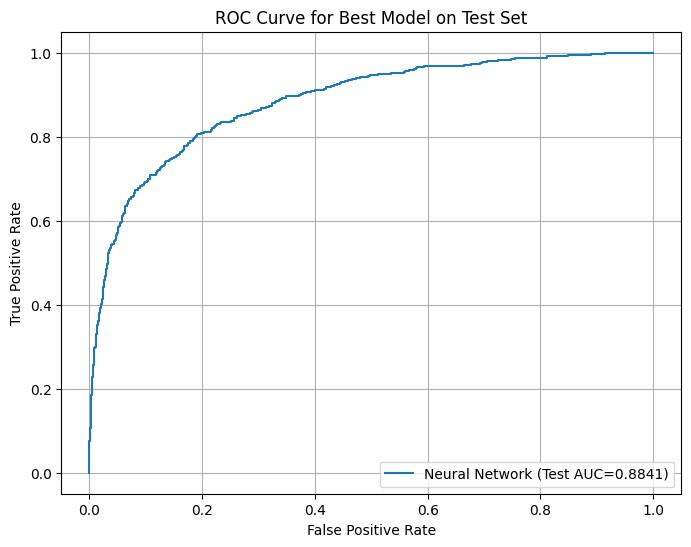

Test AUC for Neural Network: 0.8841


In [34]:
#Your code goes here

plt.figure(figsize=(8, 6))

best_nn_model = models.Sequential([layers.Input(shape=(X_train_embeddings.shape[1],)), layers.Dense(128, activation='relu'), layers.Dense(1, activation='sigmoid')
])

best_nn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

best_nn_model.fit(X_train_embeddings, y_train, epochs=10, verbose=0)

nn_test_preds = best_nn_model.predict(X_test_embeddings)
nn_test_fpr, nn_test_tpr, _ = metrics.roc_curve(test_data['is_customer_service_issue'], nn_test_preds)
nn_test_auc = metrics.roc_auc_score(test_data['is_customer_service_issue'], nn_test_preds)

plt.plot(nn_test_fpr, nn_test_tpr, label=f"Neural Network (Test AUC={nn_test_auc:.4f})")
plt.title("ROC Curve for Best Model on Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Test AUC for Neural Network: {nn_test_auc:.4f}")